In [1]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
import pandas as pd
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv

### Cora Data Set
see https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid

In [2]:
dataset = Planetoid(root='.', name='Cora')

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True,
                             normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True,
                             normalize=True)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

model = GCN(dataset.num_features, 16, dataset.num_classes)

In [3]:
model

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

In [4]:
data = dataset[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, data = model.to(device), data.to(device)

In [5]:
optimizer = torch.optim.Adam([
    dict(params=model.conv1.parameters(), weight_decay=5e-4),
    dict(params=model.conv2.parameters(), weight_decay=0)
], lr=0.01)  # Only perform weight-decay on first convolution.

In [6]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [7]:
@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index, data.edge_weight).argmax(dim=-1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs

In [8]:
best_val_acc = final_test_acc = 0
epochs=300
deets = []
for epoch in range(0, epochs):
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    if not epoch%30:
        print(f"Epoch={epoch+1}, Loss={loss}, Train={train_acc}, Val={val_acc}, Test={test_acc}")
    deets.append({"epoch":epoch, "loss": loss, "train_acc": train_acc, "val_acc": val_acc, "test_acc": test_acc})

Epoch=1, Loss=1.9467655420303345, Train=0.6142857142857143, Val=0.466, Test=0.459
Epoch=31, Loss=0.14993378520011902, Train=1.0, Val=0.782, Test=0.806
Epoch=61, Loss=0.06544520705938339, Train=1.0, Val=0.78, Test=0.806
Epoch=91, Loss=0.06431079655885696, Train=1.0, Val=0.784, Test=0.806
Epoch=121, Loss=0.037216801196336746, Train=1.0, Val=0.772, Test=0.806
Epoch=151, Loss=0.036781441420316696, Train=1.0, Val=0.776, Test=0.806
Epoch=181, Loss=0.034145042300224304, Train=1.0, Val=0.782, Test=0.806
Epoch=211, Loss=0.030908547341823578, Train=1.0, Val=0.78, Test=0.806
Epoch=241, Loss=0.03355537727475166, Train=1.0, Val=0.756, Test=0.806
Epoch=271, Loss=0.040816355496644974, Train=1.0, Val=0.776, Test=0.806


<AxesSubplot:xlabel='epoch'>

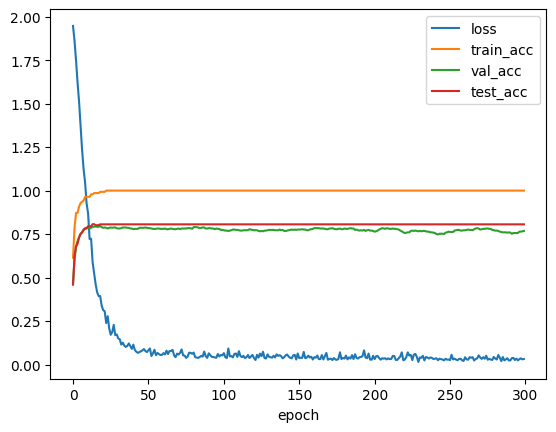

In [9]:
pd.DataFrame(deets).set_index("epoch").plot()